In [1]:
import numpy as np

from numpy import arange 

import pandas as pd

import xgboost as xgb

from xgboost import XGBClassifier

from xgboost import plot_importance

from sklearn.metrics import accuracy_score #準確率

from sklearn.model_selection import GridSearchCV #導入GridsearchCV

#讀data

dtrain=pd.read_csv("C:/Users/user80917/Desktop/train.csv")
dtest=pd.read_csv("C:/Users/user80917/Desktop/test.csv")

dtrain

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [2]:
import matplotlib.pyplot as plt

#畫各features的長方圖
dtrain.hist(bins=10,figsize=(15,8),grid=False)
plt.show()

<Figure size 1500x800 with 9 Axes>

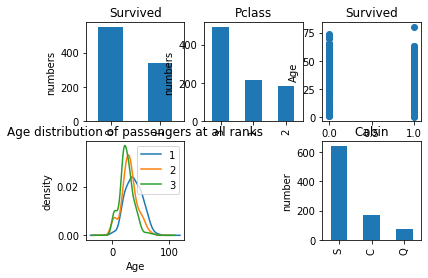

In [3]:
fig=plt.figure()
fig.set(alpha=0.2)

plt.subplot(2,3,1)
dtrain.Survived.value_counts().plot(kind='bar')
plt.title('Survived')
plt.ylabel("numbers")

plt.subplot(2,3,2)
dtrain.Pclass.value_counts().plot(kind='bar')
plt.title('Pclass')
plt.ylabel("numbers")

plt.subplot(2,3,3)
plt.scatter(dtrain.Survived,dtrain.Age)
plt.title('Survived')
plt.ylabel("Age")

plt.subplot(2,3,4)
dtrain.Age[dtrain.Pclass == 1].plot(kind='kde')   
dtrain.Age[dtrain.Pclass == 2].plot(kind='kde')
dtrain.Age[dtrain.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")# plots an axis lable
plt.ylabel("density") 
plt.title("Age distribution of passengers at all ranks")
plt.legend(('1', '2','3'),loc='best') # 設圖例

plt.subplot(2,3,6)
dtrain.Embarked.value_counts().plot(kind='bar')
plt.title("Cabin")
plt.ylabel("number")  
plt.show()

In [4]:
from sklearn.ensemble import RandomForestRegressor

### 使用 RandomForestRegressor 填補缺失的年齡屬性

def set_missing_ages(df):
    
    # 把已有的數值型features取出来丢進Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    
    # 乘客分成已知年齡和未知年齡兩部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    
    # y即目標年齡
    y = known_age[:, 0]

    # X即feature屬性值
    X = known_age[:, 1:]
    
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型進行未知年齡结果預測
    predictedAges = rfr.predict(unknown_age[:, 1:])

    # 用得到的預測结果填補原缺失data
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    return df,rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

#dtrain
dtrain, rfr = set_missing_ages(dtrain)
dtrain = set_Cabin_type(dtrain)

#dtest 先用dtrain平均填ㄅ
#dtest["Age"]=dtest["Age"].fillna(value=dtrain["Age"].mean())

dtest = set_Cabin_type(dtest)
dtest

C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,No,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,No,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,No,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,No,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,No,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,No,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,Yes,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,No,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,No,S


In [5]:
#one hot encoding-dtrain
dtrain['Embarked']=dtrain['Embarked'].fillna('S')
d_Sex=pd.get_dummies(dtrain['Sex'],prefix='Sex')
d_Pclass=pd.get_dummies(dtrain['Pclass'],prefix='Pclass')
d_Embarked=pd.get_dummies(dtrain['Embarked'],prefix='Embarked')
d_Cabin=pd.get_dummies(dtrain['Cabin'],prefix='Cabin')

#把處理後的新增回dtrain,df
dtrain=pd.concat([dtrain,d_Sex,d_Pclass,d_Embarked,d_Cabin],axis=1)
dtrain.drop(['Name','Sex','Pclass','Embarked','Cabin','Ticket'],axis=1,inplace=True)

#one hot encoding-dtest
dtest['Embarked']=dtest['Embarked'].fillna('S')
d_Sex=pd.get_dummies(dtest['Sex'],prefix='Sex')
d_Pclass=pd.get_dummies(dtest['Pclass'],prefix='Pclass')
d_Embarked=pd.get_dummies(dtest['Embarked'],prefix='Embarked')
d_Cabin=pd.get_dummies(dtest['Cabin'],prefix='Cabin')

#dtest
dtest=pd.concat([dtest,d_Sex,d_Pclass,d_Embarked,d_Cabin],axis=1)
dtest.drop(['Name','Sex','Pclass','Embarked','Cabin','Ticket'],axis=1,inplace=True)

dtest

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,892,34.5,0,0,7.8292,0,1,0,0,1,0,1,0,1,0
1,893,47.0,1,0,7.0000,1,0,0,0,1,0,0,1,1,0
2,894,62.0,0,0,9.6875,0,1,0,1,0,0,1,0,1,0
3,895,27.0,0,0,8.6625,0,1,0,0,1,0,0,1,1,0
4,896,22.0,1,1,12.2875,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
414,1306,39.0,0,0,108.9000,1,0,1,0,0,1,0,0,0,1
415,1307,38.5,0,0,7.2500,0,1,0,0,1,0,0,1,1,0
416,1308,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


In [6]:
#對age和fare標準化至(-1,1)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#dtrain
age_p=scaler.fit(dtrain[['Age']].values.reshape(-1,1))
dtrain['Age_sc']=scaler.fit_transform(dtrain[['Age']].values.reshape(-1,1),age_p)

fare_p=scaler.fit(dtrain[['Fare']].values.reshape(-1,1))
dtrain['Fare_sc']=scaler.fit_transform(dtrain[['Fare']].values.reshape(-1,1),fare_p)

dtest

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,892,34.5,0,0,7.8292,0,1,0,0,1,0,1,0,1,0
1,893,47.0,1,0,7.0000,1,0,0,0,1,0,0,1,1,0
2,894,62.0,0,0,9.6875,0,1,0,1,0,0,1,0,1,0
3,895,27.0,0,0,8.6625,0,1,0,0,1,0,0,1,1,0
4,896,22.0,1,1,12.2875,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
414,1306,39.0,0,0,108.9000,1,0,1,0,0,1,0,0,0,1
415,1307,38.5,0,0,7.2500,0,1,0,0,1,0,0,1,1,0
416,1308,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


In [7]:
#邏輯迴歸,我把df換成dtrain了
from sklearn import linear_model

#搜尋(regex)並取出(filter)"XXX_"後的...
train_dtrain=dtrain.filter(regex='Survived|Age_sc|SibSp|Parch|Fare_sc|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')

#轉為np格式
train_np=train_dtrain.as_matrix()
y=train_np[:,0]
X=train_np[:,1:]

#使用L1正則化(LASSO)
lr=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr.fit(X,y)
lr

C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=1e-06, verbose=0,
                   warm_start=False)

In [8]:
#模型係數關聯分析，正數正關聯
pd.DataFrame({"columns":list(train_dtrain.columns)[1:],
              "coef":list(lr.coef_.T)})

,columns,coef
0,SibSp,[-0.3449733010390577]
1,Parch,[-0.10572144115264033]
2,Sex_female,[1.9516254259728791]
3,Sex_male,[-0.6852678533601517]
4,Pclass_1,[0.3438679211787722]
5,Pclass_2,[0.0]
6,Pclass_3,[-1.1919729157626362]
7,Embarked_C,[0.0]
8,Embarked_Q,[0.0]
9,Embarked_S,[-0.40888622814835024]


In [9]:
from sklearn.model_selection import cross_val_score,train_test_split

#看看評分
clf1=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
all_data=train_dtrain.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
y=all_data.as_matrix()[:,0]
X=all_data.as_matrix()[:,1:]

print(cross_val_score(lr,X,y,cv=5))

#分割data,Training data:CV data=7:3
split_train,split_cv=train_test_split(dtrain,test_size=0.3,random_state=42)

train_df=split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')


#生成model
lr=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr.fit(train_df.as_matrix()[:,1:],train_df.as_matrix()[:,0])

#對 cross validation data 進行預測
cv_df=split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions=lr.predict(cv_df.as_matrix()[:,1:])

#bad cases，選取列值不等於['XX']的行
bad_cases=dtrain.loc[dtrain['PassengerId'].isin(split_cv[predictions!=cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases

C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3

[0.81564246 0.81005587 0.78651685 0.78651685 0.81355932]


,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Age_sc,Fare_sc
23,24,1,28.000000,0,0,35.5000,0,1,1,0,0,0,0,1,0,1,-0.120924,0.066360
25,26,1,38.000000,1,5,31.3875,1,0,0,0,1,0,0,1,1,0,0.613171,-0.016444
49,50,0,18.000000,1,0,17.8000,1,0,0,0,1,0,0,1,1,0,-0.855018,-0.290024
55,56,1,44.064830,0,0,35.5000,0,1,1,0,0,0,0,1,0,1,1.058386,0.066360
65,66,1,17.099916,1,1,15.2458,0,1,0,0,1,1,0,0,1,0,-0.921092,-0.341452
78,79,1,0.830000,0,2,29.0000,0,1,0,1,0,0,0,1,1,0,-2.115458,-0.064516
81,82,1,29.000000,0,0,9.5000,0,1,0,0,1,0,0,1,1,0,-0.047514,-0.457142
118,119,0,24.000000,0,1,247.5208,0,1,1,0,0,1,0,0,0,1,-0.414561,4.335332
139,140,0,24.000000,0,0,79.2000,0,1,1,0,0,1,0,0,0,1,-0.414561,0.946246
165,166,1,9.000000,0,2,20.5250,0,1,0,0,1,0,0,1,1,0,-1.515703,-0.235157


In [11]:
from sklearn.ensemble import BaggingRegressor

train_df=train_dtrain.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np=train_df.as_matrix()


#y即Survival結果
y=train_np[:,0]

#X即features屬性值
X=train_np[:,1:]

#fit到BaggingRegressor之中,with 20個logisticRegressor
clf=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
bagging_clf=BaggingRegressor(clf,n_estimators=20,max_samples=0.8,max_features=1.0,
                             bootstrap=True,bootstrap_features=False,n_jobs=-1)
bagging_clf.fit(X,y)


C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


BaggingRegressor(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l1',
                                                   random_state=None,
                                                   solver='warn', tol=1e-06,
                                                   verbose=0,
                                                   warm_start=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=0.8, n_estimators=20, n_jobs=-1, oob_score=False,
                 random_state=None, verbose=0, warm_s

In [12]:
dtest

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,892,34.5,0,0,7.8292,0,1,0,0,1,0,1,0,1,0
1,893,47.0,1,0,7.0000,1,0,0,0,1,0,0,1,1,0
2,894,62.0,0,0,9.6875,0,1,0,1,0,0,1,0,1,0
3,895,27.0,0,0,8.6625,0,1,0,0,1,0,0,1,1,0
4,896,22.0,1,1,12.2875,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
414,1306,39.0,0,0,108.9000,1,0,1,0,0,1,0,0,0,1
415,1307,38.5,0,0,7.2500,0,1,0,0,1,0,0,1,1,0
416,1308,NaN,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


In [13]:
from sklearn.ensemble import RandomForestRegressor

#對Age fit

df_Age=dtest.filter(regex='Age|Parch|SibSp|Pclass_.*')

known_age1=df_Age[dtest.Age.notnull()].as_matrix()
unknown_age1=df_Age[dtest.Age.isnull()].as_matrix()


y2=known_age1[:,0]
x2=known_age1[:,1:]

# fit到RandomForestRegressor之中
rfr=RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
rfr.fit(x2,y2)

# 用得到的模型進行未知年齡结果預測
predAges=rfr.predict(unknown_age1[:,1:])

# 用得到的預測结果填補原缺失data
dtest.loc[(dtest.Age.isnull()),'Age']=predAges

dtest

C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,892,34.500000,0,0,7.8292,0,1,0,0,1,0,1,0,1,0
1,893,47.000000,1,0,7.0000,1,0,0,0,1,0,0,1,1,0
2,894,62.000000,0,0,9.6875,0,1,0,1,0,0,1,0,1,0
3,895,27.000000,0,0,8.6625,0,1,0,0,1,0,0,1,1,0
4,896,22.000000,1,1,12.2875,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
414,1306,39.000000,0,0,108.9000,1,0,1,0,0,1,0,0,0,1
415,1307,38.500000,0,0,7.2500,0,1,0,0,1,0,0,1,1,0
416,1308,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


In [14]:
dtest["Fare"]=dtest["Fare"].fillna(value=dtest["Age"].mean())

dtest

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes
0,892,34.500000,0,0,7.8292,0,1,0,0,1,0,1,0,1,0
1,893,47.000000,1,0,7.0000,1,0,0,0,1,0,0,1,1,0
2,894,62.000000,0,0,9.6875,0,1,0,1,0,0,1,0,1,0
3,895,27.000000,0,0,8.6625,0,1,0,0,1,0,0,1,1,0
4,896,22.000000,1,1,12.2875,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
414,1306,39.000000,0,0,108.9000,1,0,1,0,0,1,0,0,0,1
415,1307,38.500000,0,0,7.2500,0,1,0,0,1,0,0,1,1,0
416,1308,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0


In [15]:
#dtest,用dtrain的mean/std標準化
age_p=scaler.fit(dtrain[['Age']].values.reshape(-1,1))
dtest['Age_sc']=scaler.fit_transform(dtest[['Age']].values.reshape(-1,1),age_p)

fare_p=scaler.fit(dtrain[['Fare']].values.reshape(-1,1))
dtest['Fare_sc']=scaler.fit_transform(dtest[['Fare']].values.reshape(-1,1),age_p)
dtest

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Age_sc,Fare_sc
0,892,34.500000,0,0,7.8292,0,1,0,0,1,0,1,0,1,0,0.371197,-0.498146
1,893,47.000000,1,0,7.0000,1,0,0,0,1,0,0,1,1,0,1.336737,-0.513013
2,894,62.000000,0,0,9.6875,0,1,0,1,0,0,1,0,1,0,2.495386,-0.464828
3,895,27.000000,0,0,8.6625,0,1,0,0,1,0,0,1,1,0,-0.208128,-0.483205
4,896,22.000000,1,1,12.2875,1,0,0,0,1,0,0,1,1,0,-0.594344,-0.418211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0,-0.275523,-0.494187
414,1306,39.000000,0,0,108.9000,1,0,1,0,0,1,0,0,0,1,0.718791,1.313990
415,1307,38.500000,0,0,7.2500,0,1,0,0,1,0,0,1,1,0,0.680170,-0.508531
416,1308,26.127490,0,0,8.0500,0,1,0,0,1,0,0,1,1,0,-0.275523,-0.494187


In [16]:
#模型預測,可再創造mother child family等特徵進行優化

df_test = dtest.filter(regex='Age_sc|SibSp|Parch|Fare_sc|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')

df_test

predictions = lr.predict(df_test)

#df_test已沒 PassengerId

result = pd.DataFrame({'PassengerId':dtest['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})

#result.to_csv("C:/Users/user80917/Desktop/RFCpredict.csv", index=False)

C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
